In [101]:
import pandas as pd
from database.database import Database
from modeler.modeler import Modeler as m
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle

In [2]:
project_name = "amazon_toys"

In [3]:
db = Database(project_name)

In [75]:
## Transform data
data = pd.read_csv("data.csv")

In [76]:
data.dtypes

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
average_review_rating                           object
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object

In [77]:
data["number_available_in_stock"] = data["number_available_in_stock"].str.replace(r'\xa0|^ ','')
data["number_available_in_stock"] = data["number_available_in_stock"].str.replace(r'new|^ ','')
data["number_available_in_stock"] = data["number_available_in_stock"].str.replace(r'used|^ ','')
data["number_available_in_stock"] = data["number_available_in_stock"].str.replace(r'collectible|^ ','')
data["number_available_in_stock"] = data["number_available_in_stock"].str.replace(r'refurbished|^ ','')
data.fillna(-99999,inplace=True)
data["price"] = [float(str(x).replace(",","").split(" ")[0][1:]) if x != -99999 else 0 for x in data["price"]]
data["number_available_in_stock"] = [float(value) if value != -99999 else 0 for value in data["number_available_in_stock"]]

In [79]:
data["number_of_reviews"] = [int(str(x).replace(",","")) for x in data["number_of_reviews"]]

In [80]:
data["number_of_answered_questions"] = [int(x) for x in data["number_of_answered_questions"]]

In [81]:
data["average_review_rating"] = [float(str(x).split(" ")[0]) for x in data["average_review_rating"]]

In [91]:
## Refine Data
## if classification make appropriate changes
factors = ["number_of_answered_questions","number_available_in_stock","number_of_reviews","average_review_rating"]
label = "price"
data["y"] = data[label]
data.drop(label,axis=1)
data = data.sample(frac=1)
train = data.iloc[:int(data.index.size * 0.7)]
test = data.iloc[int(data.index.size * 0.7):]
X = train[factors]
y = train[["y"]]
y["y_class"] = 1
refined_data = {"X":X,"y":y}

In [92]:
## Model
model = m.regression(refined_data,ranked=False,tf=False,deep=False,sk=True,xgb=True)

In [98]:
model

api                                                         skl
model         RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, ...
score                                              -0.000254892
model_type                                           regression
Name: 1, dtype: object

In [94]:
## Test Model
predictions = [x[0] for x in model["model"].predict(test[factors])]
test["predictions"] = predictions

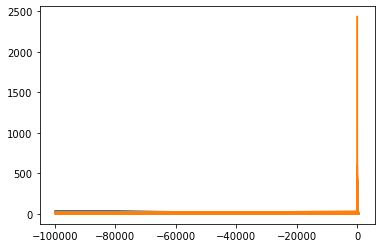

In [96]:
## Visualize
index = "number_of_reviews"
plt.plot(test[index],test["predictions"])
plt.plot(test[index],test[label])

In [102]:
## Store Model
model["model"] = pickle.dumps(model["model"])
db.connect()
db.store_data("model",pd.DataFrame([model]))
db.close()